In [1]:
#!/usr/bin/env python3

# Script to average of the time series of the Vmax error from all directories 
# and create a single matrix.
# inputs are start hour, end hour and interval at which the perturbation 
# are introduced. Start hour is generally 540 and end hour is generally 4321 (all in mins), with interval 180 mins
# Author: Kushal


#def verr_avg(hstrt,hend,interval):
import numpy as np
import os
import sys

sst='303'

def readdata(exp_time_mins):
    exp_time = '{:05d}'.format(exp_time_mins)
    path = "/Users/kkeshava/Downloads/Work/Model/HWRF/Excel_files/data/SST_experiment/"+sst+"/"
    #   print("now in time t = " + str(time))
    #   os.system("cd " + dir+" ; ./vmax_tseries.sh exp_"+str(time).zfill(5))
    with open(path+"time_series_exp_"+exp_time+".txt") as f:
        data = f.readlines()
    data_np = np.array([line.split()[1] for line in data]) 
    return data_np



def verr_calculate_representative(hstrt,hend,pert_interval):
    """
   Returns verr and v_ref which is the error matrix and reference velocity.
  """
  
    i=1
    #vout = np.zeros((121,23),dtype=np.float64)
    verr = np.zeros((121,23),dtype=np.float64)
    v_ref = np.array(readdata(0),dtype=np.float64)

    for time in range(hstrt,hend+1,pert_interval):
        vmean_np = np.zeros((121,))
        try:
            for j in range(-6,7,3):
                try:
                    #print(i, (time + j))
                    #t = str(time + j).zfill(5)
                    # data_np = readdata(t)
                    data_np = np.array(readdata((time + j)),dtype=np.float64)
                    vmean_np = vmean_np + data_np
                except:
                    continue
            vmean_np = vmean_np/5.
            #vout[:,i] = vmean_np
            verr[:,i] = vmean_np - v_ref
            i += 1
        except:
            continue
    #vout[:,0] = v_ref[:]
    verr = abs(verr)
    
    saveas = '/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/sst_perturbation/'+sst+'/verr'
    np.save(saveas, verr)
    return verr, v_ref

def verr_calculate(hstrt,hend,pert_interval):
    """
   Returns verr and v_ref which is the error matrix and reference velocity.
  """
  
    i=1
    #vout = np.zeros((121,23),dtype=np.float64)
    verr = np.zeros((121,23),dtype=np.float64)
    v_ref = np.array(readdata(0),dtype=np.float64)
    
    for time in range(hstrt,hend+1,pert_interval):
        try:
            data_np = np.array(readdata((time)),dtype=np.float64)
            verr[:,i] = data_np - v_ref
            i += 1
        except:
            continue
    #vout[:,0] = v_ref[:]
    verr = abs(verr)
    
    saveas = '/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/sst_perturbation/'+sst+'/verr'
    np.save(saveas, verr)
    return verr, v_ref


#saveas = '/N/u/kkeshava/scratch/hwrf-dtc-br2/experiment1/averaged_timeseries/verr_averaged.txt'
#np.savetxt(saveas,verr,fmt='%.3f',delimiter=' ,',newline='\n')
#return verr

In [2]:
verr, v_ref = verr_calculate(540, 4320, 180)

This works for scipy versions below 0.19.1

``` py
%reset -s
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.interpolate import spline


seaborn.set_style('darkgrid')

verr = np.load('/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/amplitude_perturbation/experiment1-d02-1ms-1/verr.npy')
xnew = np.linspace(0,120, 500)
verr_smooth = np.zeros((xnew.shape[0], verr.shape[1]))
print(verr_smooth.shape)
for i in range(verr.shape[1]):
    verr_smooth[:, i] = spline(np.arange(verr.shape[0]),verr[:,i], xnew)
hr = [0]
for i in range(9,73, 3):
    hr.append(i)
#fig, ax = plt.subplots(figsize=(14,6))
plt.gcf().set_size_inches((12, 5))
for i in range(1,verr_smooth.shape[1]):
    plt.plot(xnew, verr_smooth[:,i], label=str(hr[i])+'hr', lw=2.5)
    plt.xlim(0,126)
    plt.ylim(0,6)
colormap = plt.cm.gist_rainbow
colors = [colormap(i) for i in np.linspace(0, 1,len(plt.gca().lines))]
#np.random.seed(120)
for i, j in enumerate(plt.gca().lines):
    j.set_color(colors[i])
#    j.set_color(colors[np.random.randint(len(plt.gca().lines))])
#    j.set_alpha(0.5)
plt.legend(loc=2, ncol=6)
plt.title(r'$V_{max}$ Error Growth (Domain 1 and Domain 2)')
plt.title(r'Pertubation Amplitude = 1 ms$^{-1}$', loc = 'right')
plt.gca().set_xticks(np.arange(0, 121, 12))
plt.gca().set_xticklabels([str(i) + 'hr' for i in range(0,121, 12)])
plt.savefig('/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/amplitude_perturbation/experiment1-d02-1ms-1/vmax_error_timeseries_experiment1.pdf', \
           format='pdf', dpi=200)
plt.show()

plt.close('all')
```

The code below works for scipy versions 0.19.1 and above.

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
(500, 23)


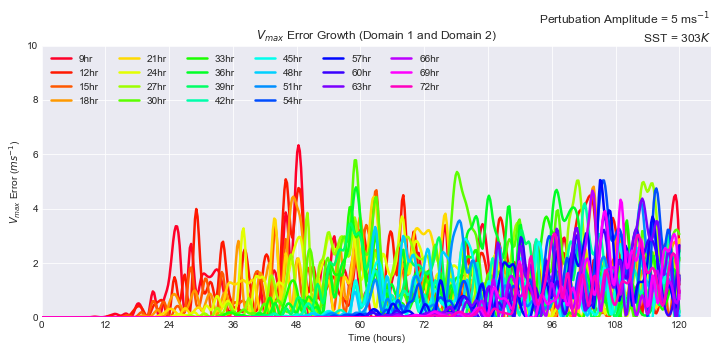

In [3]:
# Plot the timeseries

%reset -s
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.interpolate import InterpolatedUnivariateSpline


seaborn.set_style('darkgrid')

sst = '303'

verr = np.load('/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/sst_perturbation/'+sst+'/verr.npy')
xnew = np.linspace(0,verr.shape[0] - 1 , 500)
verr_smooth = np.zeros((xnew.shape[0], verr.shape[1]))

# Making data fit to a spline for smooth curves
print(verr_smooth.shape)
for i in range(verr.shape[1]):
    f = InterpolatedUnivariateSpline(np.arange(verr.shape[0]), verr[:,i])
    verr_smooth[:, i] = f(xnew)

# Values for the tick labels
hr = [0]
for i in range(9,73, 3):
    hr.append(i)
    
plt.gcf().set_size_inches((12, 5))

# Plotting
for i in range(1,verr_smooth.shape[1]):
    plt.plot(xnew, verr_smooth[:,i], label=str(hr[i])+'hr', lw=2.5)
    plt.xlim(0,126)
    plt.ylim(0,10)

# Setting colors to individual lines
colormap = plt.cm.gist_rainbow
colors = [colormap(i) for i in np.linspace(0, 1,len(plt.gca().lines))]

# If random coloring is required, set a seed so that
# you will get the same random numbes every time you call np.random
#np.random.seed(120)

for i, j in enumerate(plt.gca().lines):
    j.set_color(colors[i])
#    j.set_color(colors[np.random.randint(len(plt.gca().lines))]) # For random line colors within the selected colormap
#    j.set_alpha(0.5) # Set transparency

# Beautifying the plot
plt.legend(loc=2, ncol=6)
plt.title(r'$V_{max}$ Error Growth (Domain 1 and Domain 2)')
plt.title('Pertubation Amplitude = 5 ms$^{-1}$ \n SST = '+sst+'$K$', loc = 'right')
plt.ylabel(r'$V_{max}$ Error ($ms^{-1}$)')
plt.xlabel(r'Time (hours)')
plt.gca().set_xticks(np.arange(0, 121, 12))
#plt.gca().set_xticklabels([str(i) + 'hr' for i in range(0,121, 12)])
plt.savefig('/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/sst_perturbation/'+sst+'/vmax_error_timeseries_'+sst+'K.pdf', \
           format='pdf', dpi=200)
plt.show()
plt.close('all')



Once deleted, variables cannot be recovered. Proceed (y/[n])? y


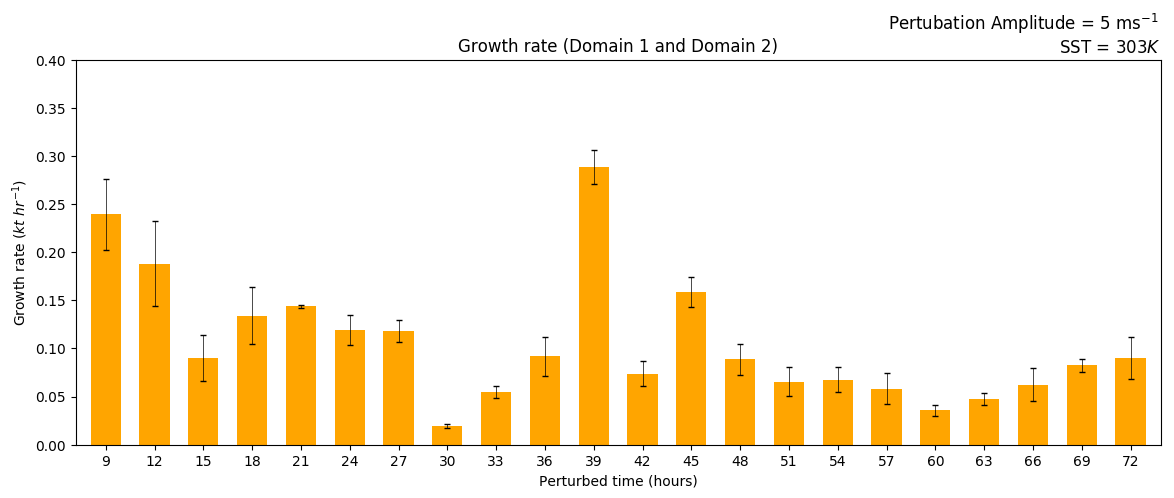

In [4]:
# Plot the timeseries

%reset -s
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

sst = '303'
plt.style.use('default')
verr = np.load('/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/sst_perturbation/'+sst+'/verr.npy')
# Values for the tick labels
hr = [0]
for i in range(9,73, 3):
    hr.append(i)

x = np.linspace(0,120, 121)

gr_ms, gr_sd = np.zeros(verr.shape[1]-1), np.zeros(verr.shape[1]-1) # Growth rate in ms-1 and its standard deviation
for i,j in enumerate(range(9, 73, 3)):
    gr_ms[i] = np.average(verr[j+16:j+20, i+1])
    gr_sd[i] = np.std(verr[j+16:j+20, i+1])
# gr_sd[i] = np.std(gr_ms)
#print(gr_ms, '\n\n', gr_sd)

gr_kt = gr_ms/9.

# bar properties for plot
width = 1.85

plt.gcf().set_size_inches((14, 5))

# Plotting
# for i in range(1,verr.shape[1]):
#     plt.plot(x, verr_smooth[:,i], label=str(hr[i])+'hr', lw=2.5)


plt.bar(np.arange(9, 73, 3), gr_kt, width, color='orange', alpha=1)
plt.errorbar(np.arange(9, 73, 3), gr_kt, yerr=gr_sd/(np.sqrt(3)*18), fmt='none', capsize=2, \
             dash_capstyle='butt', elinewidth=0.5, ecolor='k')


# Beautifying the plot
#plt.legend(loc=2, ncol=6)
plt.title(r'Growth rate (Domain 1 and Domain 2)')
plt.title('Pertubation Amplitude = 5 ms$^{-1}$ \n SST = '+sst+'$K$', loc = 'right')
plt.ylabel(r'Growth rate ($kt\ hr^{-1}$)')
plt.xlabel(r'Perturbed time (hours)')
plt.gca().set_xticks(np.arange(0, 73, 3))
plt.gca().set_yticks(np.arange(0, 0.41, 0.05))
plt.xlim(9-width,72+width)
plt.ylim(0,0.4)

#plt.gca().spines['left'].set_smart_bounds(9)
#plt.gca().set_xticklabels([str(i) + 'hr' for i in range(0,121, 12)])
plt.savefig('/Users/kkeshava/Downloads/Work/Model/HWRF/Plots/Idealized/sst_perturbation/'+sst+'/growth_rate_'+sst+'K.pdf', \
            format='pdf', dpi=200)
plt.show()
plt.close('all')


